In [1]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from matplotlib import tight_layout
import pandas as pd
import seaborn as sns
import segmentation_models_pytorch as smp
#from segmentation_models_pytorch.utils.train import ValidEpoch
#from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Precision, Recall, Accuracy


/tmp/ipykernel_5981/1075174138.py:5: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib import tight_layout


In [2]:
PATH_TO_DIR = '/home/broens/Documents/for_slurm/output/predictions'
PATH_TO_X = os.path.join(PATH_TO_DIR, 'imgs.npy')
PATH_TO_Y_TRUE = os.path.join(PATH_TO_DIR, 'masks.npy')
PATH_TO_Y_PRED = os.path.join(PATH_TO_DIR, 'pred_masks.npy')
X = np.load(PATH_TO_X)
Y_true = np.load(PATH_TO_Y_TRUE)
Y_pred = np.load(PATH_TO_Y_PRED)


In [3]:
print(f'X.shape: {X.shape}.\nY_true.shape: {Y_true.shape}.\nY_pred.shape: {Y_pred.shape}')

X.shape: (925, 4, 512, 512).
Y_true.shape: (925, 1, 512, 512).
Y_pred.shape: (925, 1, 512, 512)


In [4]:
# Sigmoid of Y_pred
def sigmoid(X):
    return 1/(1 + np.exp(-X))
def binarize(X):
    return (sigmoid(X) > 0.5).astype(np.float32)
#Y_pred = binarize(Y_pred)
#Y_pred.shape

In [5]:
pred_pos = np.sum(Y_pred.flatten())
pred_neg = np.sum(1 - Y_pred.flatten())
print("Number of positive predictions: ", pred_pos)
print("Number of negative predictions: ", pred_neg)
ratio = pred_pos / pred_neg
print("Ratio of positive to negative predictions: ", ratio)

Number of positive predictions:  90219640.0
Number of negative predictions:  152264210.0
Ratio of positive to negative predictions:  0.59252036


In [6]:
# Check if all Y_pred are 0
print(np.sum(Y_pred))
Y_pred = Y_pred.squeeze()
print(Y_pred.shape)

90219640.0
(925, 512, 512)


In [17]:


from matplotlib import cm


def get_idxs(N = 3, random = True):
    # Get indexes where the true mask is not all 0
    idxs = np.where(np.sum(Y_true, axis = (1,2,3)) != 0)[0]
    # Randomly choose N indexes where the true mask is not all 0 
    if N > len(idxs):
        N = len(idxs)
    if random:
        idxs = np.random.choice(idxs, N, replace = False)
    else:
        idxs = idxs[:N]
    return idxs, N
def plot_x(x, ax, channels = [3,2,1], q = 0.0125, title = None):
    if x.ndim == 4:
        x = x.squeeze()
    # The channels are along the axis of size 4
    channel_dim = np.where(np.array(x.shape) == 4)[0][0]
    not_channel_dims = np.where(np.array(x.shape) != 4)[0]
    # Index out the channels of choice along channel_dim
    x = x.transpose(*np.concatenate([not_channel_dims, [channel_dim]]))[..., channels]
    # Normalize the image and clip the outliers
    q0, q1 = min([q,1-q]), max([q,1-q])
    x = x - x.min()
    x = x / x.max()
    x = (255*np.clip(x, q0, q1)).astype(np.uint8)
    ax.imshow(x)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')
    return ax
def plot_y(y, ax, color = None, title = None):
    # The mask contains 0s and 1s. 
    y = (y.squeeze()*255).astype(np.uint8)
    y = np.stack([y,y,y], axis = -1)
    # Give the mask a color
    if color is None:
        # Rainbow colormap
        cmap = cm.get_cmap('rainbow')
        y = cmap(y[..., 0])[..., :3]
    elif color == 'red':
        y[..., 1] = 0
        y[..., 2] = 0
    elif color == 'green':
        y[..., 0] = 0
        y[..., 2] = 0
    elif color == 'blue':
        y[..., 0] = 0
        y[..., 1] = 0
    elif color == 'yellow':
        y[..., 2] = 0
    elif color == 'magenta':
        y[..., 1] = 0
    elif color == 'cyan':
        y[..., 0] = 0
    ax.imshow(y)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')
    return ax

/tmp/ipykernel_5981/3559242485.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')


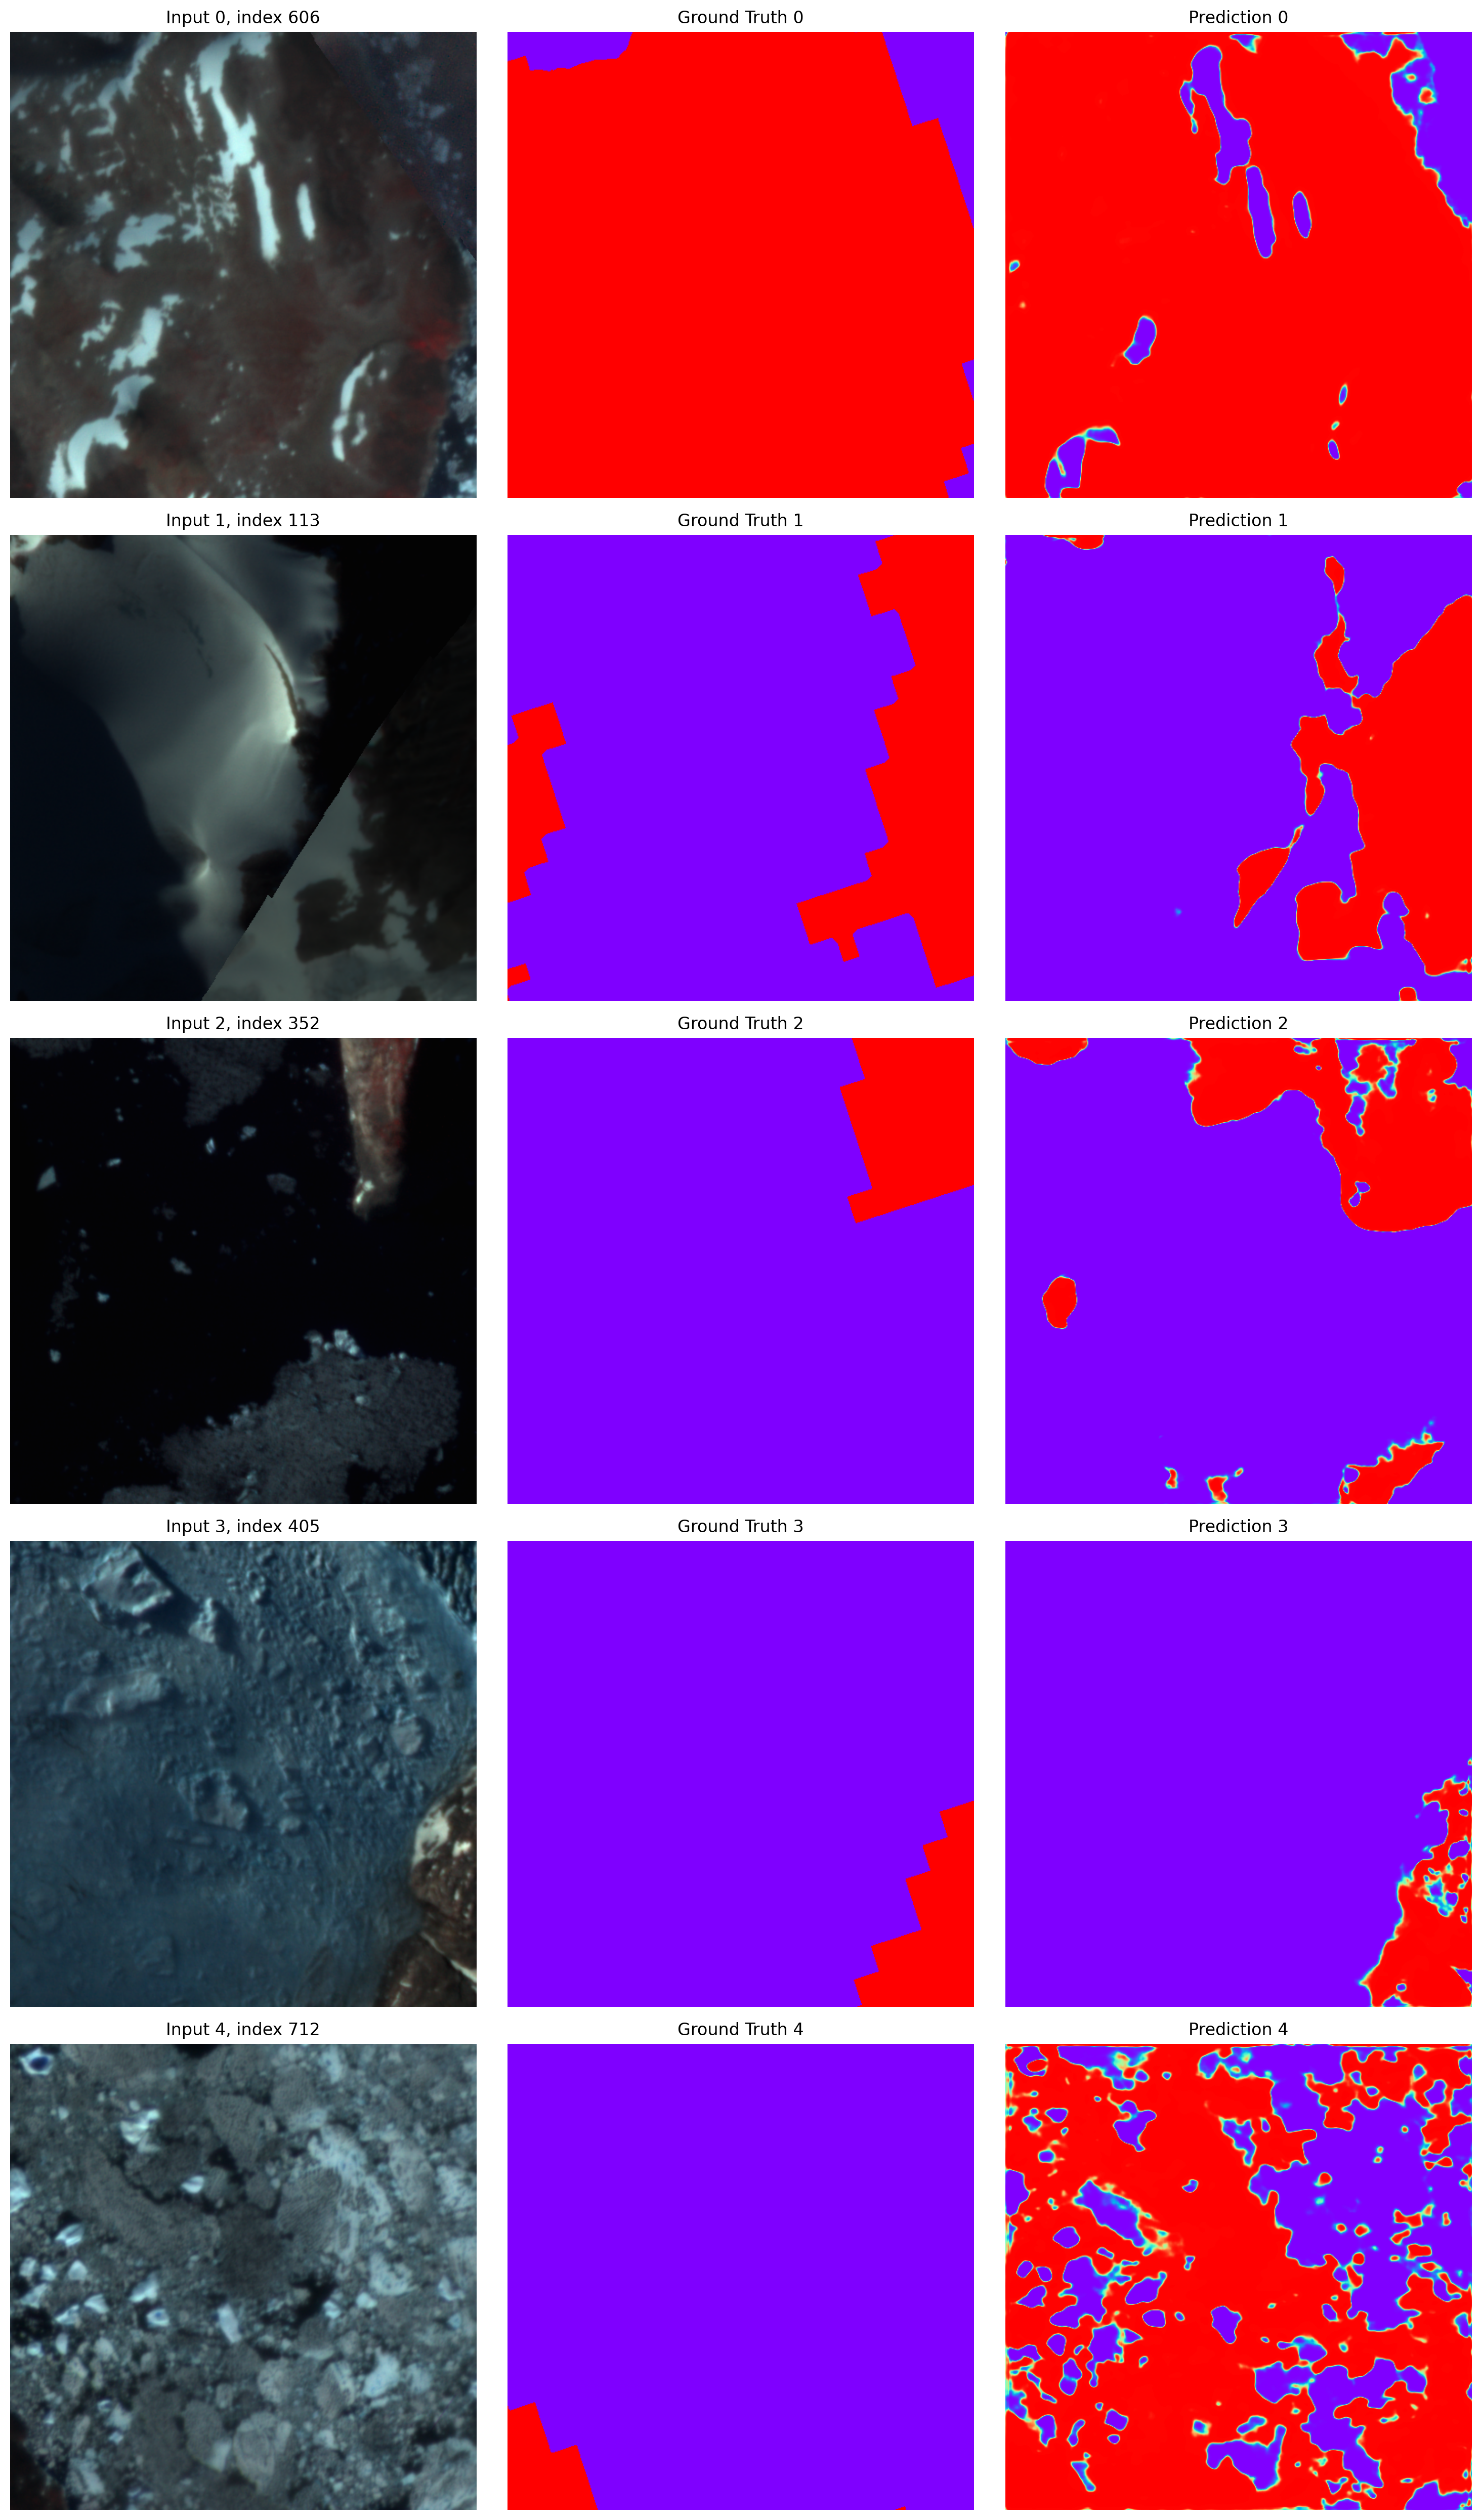

In [18]:
def plot_set(N=3, X=X, Y_true=Y_true, Y_pred=Y_pred, random=True):
    idxs, N = get_idxs(N=N, random=random)
    X = X[idxs]
    Y = Y_true[idxs]
    Y_hat = Y_pred[idxs]
    fig, axes = plt.subplots(N, 3, figsize=(15, 5*N), sharex=True, sharey=True, dpi=200, tight_layout=True)
    for i, (x, y, y_hat) in enumerate(zip(X, Y, Y_hat)):
        axis = axes[i] if N > 1 else axes
        axis[0] = plot_x(x, ax=axis[0], title=f'Input {i}, index {idxs[i]}')
        axis[1] = plot_y(y, ax=axis[1], title=f'Ground Truth {i}')
        axis[2] = plot_y(y_hat, ax=axis[2], title=f'Prediction {i}')
        plt.setp(axis[0].get_xticklabels(), visible=True)
        plt.setp(axis[1].get_xticklabels(), visible=True)
        plt.setp(axis[2].get_xticklabels(), visible=True)
    plt.show()

plot_set(N=5, random=True)


In [9]:
def plot_4B_sat_img(x = X, quantile = 0.975):
    fig, ax = plt.subplots(1, 4, figsize=(12, 4), sharey=True, sharex=True, tight_layout=True, dpi=300)
    band_names = ['B', 'G', 'R', 'NIR']
    for i in range(x.shape[0]):
        intensity_i = x[i]
        maximal_intensity = np.max(intensity_i)
        minimal_intensity = np.min(intensity_i)
        sat_intensity = np.quantile(intensity_i, quantile)
        ax[i].imshow(intensity_i, vmin=minimal_intensity, vmax=sat_intensity)
        ax[i].set_title(f'{band_names[i]} band')
        ax[i].axis('off')
    plt.show()
#plot_4B_sat_img()

TypeError: Invalid shape (925, 1, 512, 512) for image data

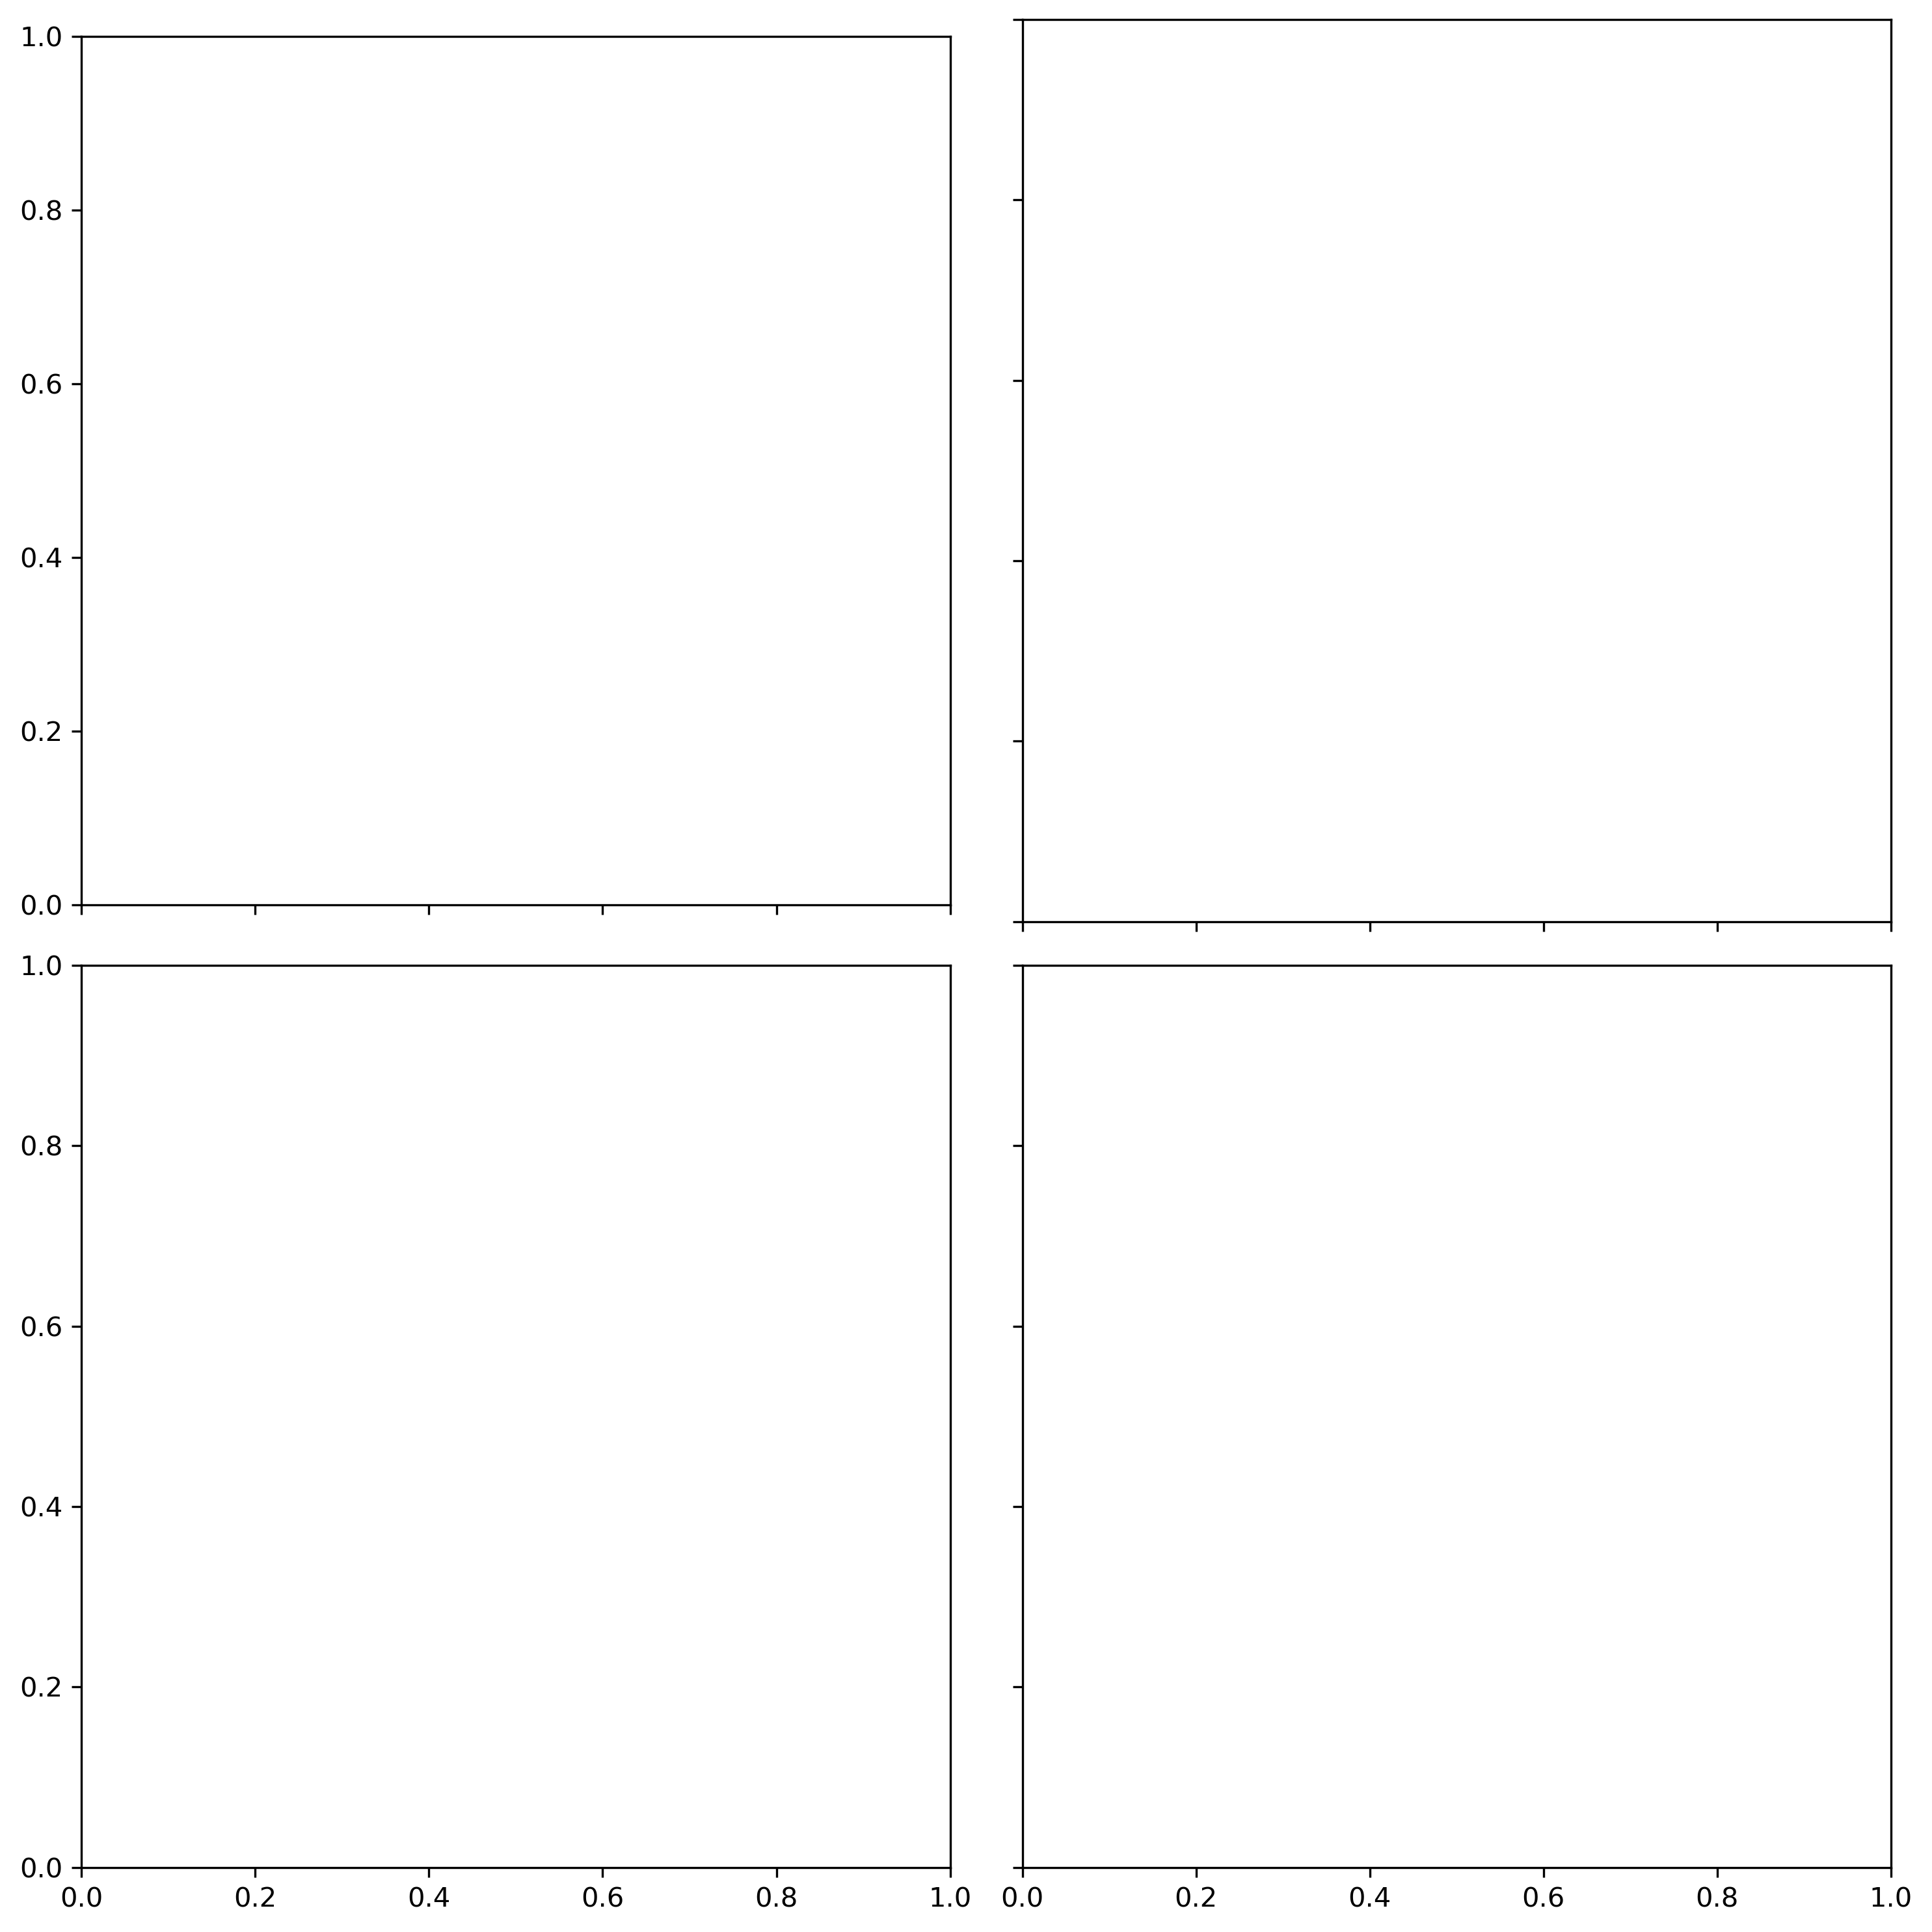

In [10]:
def plot_y_true_pred(x = X, y_true=Y_true, y_pred=Y_pred, q=0.05):
    """
    Plot the true and predicted images with, and without, the background.
    """
    fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True, tight_layout=True, dpi=300)
    ax[0, 0].imshow(y_true)
    ax[0, 0].set_title('True')
    ax[0, 1].imshow(y_pred)
    ax[0, 1].set_title('Predicted')
    sat_img = x[[3, 2, 1], :, :].transpose((1, 2, 0))
    qmin = min([q, 1.0-q])
    qmax = max([q, 1.0-q])
    maximal_intensity = np.quantile(sat_img, q=q)
    minimal_intensity = np.quantile(sat_img, q=1.0-q)
    sat_img = np.clip(sat_img, a_min=minimal_intensity, a_max=maximal_intensity)
    ax[1, 0].imshow(sat_img, vmin=minimal_intensity, vmax=maximal_intensity)
    ax[1, 0].imshow(y_true, alpha=0.2, vmin=0.0, vmax=1.0)
    ax[1, 0].set_title('Satellite image with true mask')
    ax[1, 1].imshow(sat_img, vmin=minimal_intensity, vmax=maximal_intensity)
    ax[1, 1].imshow(y_pred, alpha=0.2, vmin=0.0, vmax=1.0)
    ax[1, 1].set_title('Satellite image with predicted mask')
    plt.show()

plot_y_true_pred()